# Importing dependencies

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Loading

In [0]:
dataset_train = torchvision.datasets.MNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Initializing constants

In [3]:
torch.cuda.is_available()

True

In [0]:
epochs = 20
output_after_every_n = 5
image_size = 28
input_size = 100
batch_size = 64
num_channels = 1
num_classes = len(dataset_train.classes)

In [0]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Convert into DataLoader

In [0]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(datasetloader)

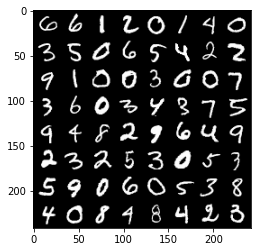

In [8]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [0]:
def initialize_weights(m): 
	if type(m)==nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)

# Generator

In [0]:
class Generator(nn.Module):
  '''
  Generator neural network
  '''
  def __init__(self):
    super(Generator, self).__init__()

    self.label_emb = nn.Embedding(num_classes, num_classes)

    # First layer input -> (features + 10)
    self.model = nn.Sequential(
                            nn.Linear(input_size + num_classes, 128),
                            nn.LeakyReLU(0.2, inplace=True),

                            nn.Linear(128, 256),
                            nn.BatchNorm1d(256, 0.8),
                            nn.LeakyReLU(0.2, inplace=True),

                            nn.Linear(256, 512),
                            nn.BatchNorm1d(512, 0.8),
                            nn.LeakyReLU(0.2, inplace=True),

                            nn.Linear(512, 1024),
                            nn.BatchNorm1d(1024, 0.8),
                            nn.LeakyReLU(0.2, inplace=True),

                            nn.Linear(1024, 28 ** 2),
                            nn.Tanh()
                  )
    
    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))
    
  def forward(self, noise, labels):
    #Concat label embedding and image to produce input
    gen_input = torch.cat((self.label_emb(labels), noise), -1)
    img = self.model(gen_input)
    img = img.view(img.size(0), 1, image_size, image_size)
    return img

generator = Generator()

In [11]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


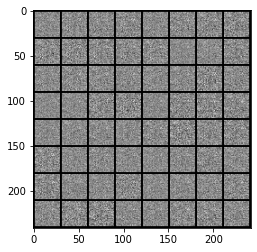

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [12]:
with torch.no_grad():
  generator.eval()
  _, labels = dataiter.next()
  noise = torch.randn(size=(batch_size, input_size)).cuda()
  output = generator(noise, labels.cuda()).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator

In [0]:
class Discriminator(nn.Module):
  '''
  Discriminator neural network
  '''
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_emb = nn.Embedding(num_classes, num_classes)

    # First layer input -> (28 * 28 + 10)
    self.model = nn.Sequential(
                          nn.Linear(num_classes + 28 ** 2, 512),
                          nn.LeakyReLU(0.2, inplace=True),

                          nn.Linear(512, 512),
                          nn.Dropout(0.4),
                          nn.LeakyReLU(0.2, inplace=True),

                          nn.Linear(512, 512),
                          nn.Dropout(0.4),
                          nn.LeakyReLU(0.2, inplace=True),

                          nn.Linear(512, 1)
    )


    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))


  def forward(self, img, labels):
    #Concat label embedding and image to produce input
    dis_input = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
    validity = self.model(dis_input)
    return validity

In [14]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

# Loss Function

In [0]:
MSE_loss = torch.nn.MSELoss()

# Plotting output after each epoch

In [0]:
def plot_output():
  plt.clf()
  with torch.no_grad():
    input_noise = torch.randn(size=(num_classes, input_size)).cuda()
    fake_labels = torch.tensor([i for i in range(10)]).cuda()
    
    generator.eval()
    test_images = generator(input_noise, fake_labels)
    generator.train()
  
  show_grid(torchvision.utils.make_grid(test_images.cpu(), normalize=True, nrow=5))

# Training CGAN

Epoch: 1 / 20
Discriminator Total Loss: 0.132, Generator Total Loss: 0.596
Epoch: 2 / 20
Discriminator Total Loss: 0.126, Generator Total Loss: 0.603
Epoch: 3 / 20
Discriminator Total Loss: 0.130, Generator Total Loss: 0.581
Epoch: 4 / 20
Discriminator Total Loss: 0.148, Generator Total Loss: 0.526
Epoch: 5 / 20
Discriminator Total Loss: 0.153, Generator Total Loss: 0.514


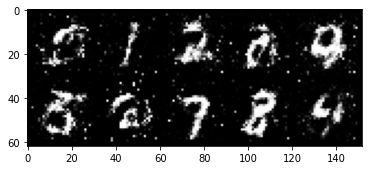

Epoch: 6 / 20
Discriminator Total Loss: 0.171, Generator Total Loss: 0.463
Epoch: 7 / 20
Discriminator Total Loss: 0.182, Generator Total Loss: 0.438
Epoch: 8 / 20
Discriminator Total Loss: 0.192, Generator Total Loss: 0.414
Epoch: 9 / 20
Discriminator Total Loss: 0.202, Generator Total Loss: 0.390
Epoch: 10 / 20
Discriminator Total Loss: 0.205, Generator Total Loss: 0.383


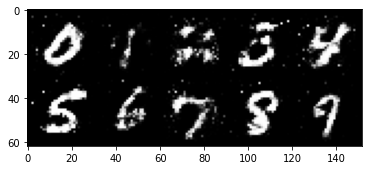

Epoch: 11 / 20
Discriminator Total Loss: 0.213, Generator Total Loss: 0.364
Epoch: 12 / 20
Discriminator Total Loss: 0.217, Generator Total Loss: 0.354
Epoch: 13 / 20
Discriminator Total Loss: 0.222, Generator Total Loss: 0.342
Epoch: 14 / 20
Discriminator Total Loss: 0.226, Generator Total Loss: 0.330
Epoch: 15 / 20
Discriminator Total Loss: 0.226, Generator Total Loss: 0.330


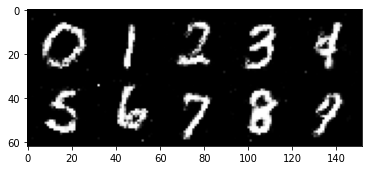

Epoch: 16 / 20
Discriminator Total Loss: 0.228, Generator Total Loss: 0.325
Epoch: 17 / 20
Discriminator Total Loss: 0.229, Generator Total Loss: 0.321
Epoch: 18 / 20
Discriminator Total Loss: 0.230, Generator Total Loss: 0.318
Epoch: 19 / 20
Discriminator Total Loss: 0.231, Generator Total Loss: 0.315
Epoch: 20 / 20
Discriminator Total Loss: 0.233, Generator Total Loss: 0.309


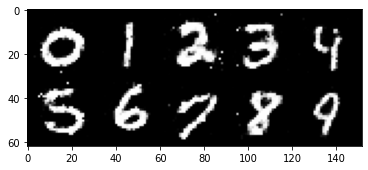

True

In [17]:
# Set tdqm for epoch progress
pbar = tqdm()

for epoch in range(epochs):
  print(f'Epoch: {epoch + 1} / {epochs}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []
  accuracy_history = []

  for real_images, real_labels in datasetloader:
    
    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.cuda()

    # For real vs fake
    real_validity = torch.ones(current_batch_size).cuda()
    fake_validity = torch.zeros(current_batch_size).cuda()


    # Training generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, input_size)).cuda()
    fake_labels = torch.randint(num_classes, size=(current_batch_size, )).cuda()
    
    fake_images = generator(input_noise, fake_labels)


    discriminator_fake_validity = discriminator(fake_images, fake_labels)
    
    generator_loss = MSE_loss(discriminator_fake_validity.squeeze(), real_validity)
    generator_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_loss)
    

    #Train discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_validity = discriminator(real_images, real_labels)
    discriminator_real_loss = MSE_loss(discriminator_real_validity.squeeze(), real_validity)

    ## Loss for fake images
    discriminator_fake_validity = discriminator(fake_images.detach(), fake_labels)
    discriminator_fake_loss = MSE_loss(discriminator_fake_validity.squeeze(), fake_validity)

    # Total discriminator loss
    discriminator_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
    discriminator_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))


  if (epoch + 1) % output_after_every_n == 0:
    plot_output()

pbar.refresh()

# Output

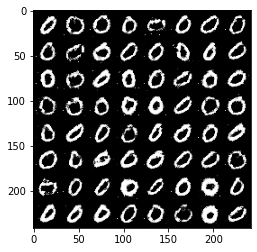

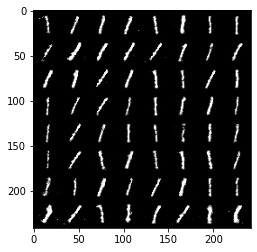

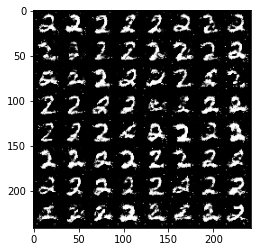

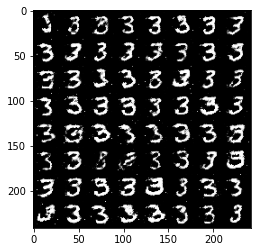

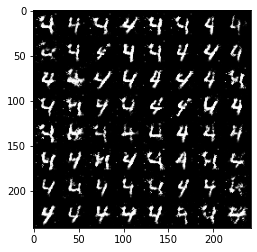

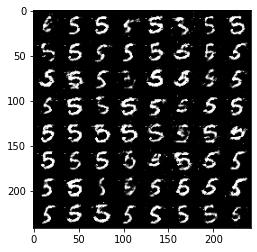

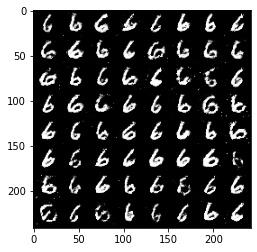

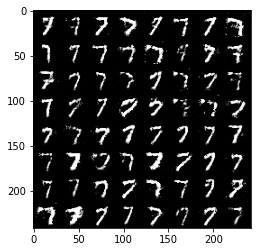

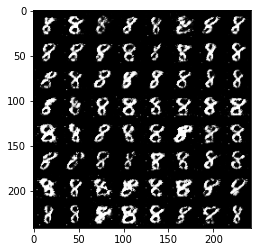

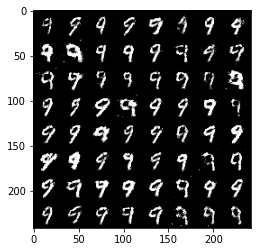

In [23]:
with torch.no_grad():
  generator.eval()

  for num in range(10):
    input_noise = torch.randn(size=(batch_size, input_size)).cuda()
    input_labels = torch.tensor([num for _ in range(batch_size)]).cuda()

    output = generator(input_noise, input_labels)

    show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))